# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Creating Mandlebrot Set

In [1]:
import Mandelbrot
import MonteCarloIntegration
import ColorfulMandelbrotSet

d:\UvA VU\Stochastic Simulations\StoSimRepository\StoSim\ColorfulMandelbrotSet.py:23: RuntimeWarning: overflow encountered in square
  Z = Z**2 + C
d:\UvA VU\Stochastic Simulations\StoSimRepository\StoSim\ColorfulMandelbrotSet.py:23: RuntimeWarning: invalid value encountered in square
  Z = Z**2 + C
d:\UvA VU\Stochastic Simulations\StoSimRepository\StoSim\ColorfulMandelbrotSet.py:24: RuntimeWarning: overflow encountered in absolute
  addition = np.abs(Z) < 10


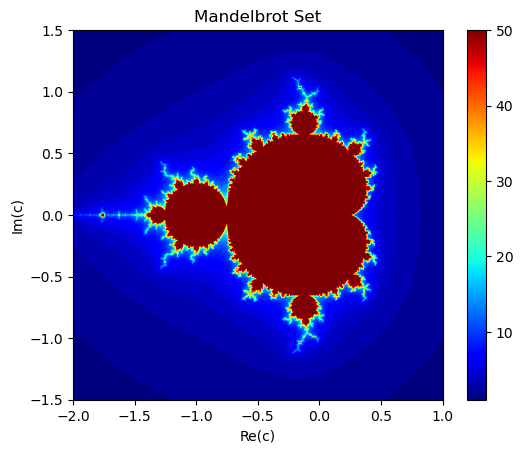

In [2]:
from ColorfulMandelbrotSet import mandelbrot_Set_Image
mandelbrot_Set_Image(-2, 1, -1.5, 1.5, 3000, 3000, 50)

# Area of Mandlebrot Set using Monte Carlo Method

In [7]:
from MonteCarloIntegration import randomSampling
print(randomSampling(-2, 2, 10, 500))

1.984


# Convergence studies for various number of iterations and samples

# Using varous sampling techniques  

# Approach for improving convergence

In [11]:
from QuasiMonteCarlo import quasiMC
quasiMC(-2,2,50,100000)

9937


1.58992